# Face Recognition using MLP with Different Activation Functions

This notebook implements a face recognition system using Multi-Layer Perceptron (MLP) with various activation functions. The project follows these steps:

1. Load and explore the facial image dataset
2. Extract features using different methods (RGB, HSV, HoG, GLCM)
3. Save extracted features to CSV files
4. Build MLP models with different activation functions
5. Train and evaluate each model
6. Compare performance metrics and determine the best activation function

## 1. Import Required Libraries

In [2]:
# Basic libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Using standard tqdm instead of tqdm.notebook

# Image processing
import cv2
from skimage.feature import hog
from skimage.feature import graycomatrix, graycoprops
from skimage import color

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Neural networks
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 2. Load and Explore the Dataset

In [3]:
# Define the dataset directory
dataset_dir = "dataset"

In [4]:
# Function to load images and labels
def load_dataset(dataset_dir):
    images = []
    labels = []
    person_dirs = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
    
    for person_dir in person_dirs:
        person_path = os.path.join(dataset_dir, person_dir)
        person_id = person_dir.split("_")[0]  # Extract NRP as ID
        person_name = person_dir.split("_")[1]  # Extract name
        
        image_files = [f for f in os.listdir(person_path) if f.endswith((".jpg", ".png"))]
        
        print(f"Loading {len(image_files)} images for {person_name} (ID: {person_id})")
        
        for img_file in tqdm(image_files):
            img_path = os.path.join(person_path, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
                images.append(img)
                labels.append(person_name)
    
    return images, labels

# Load the dataset
images, labels = load_dataset(dataset_dir)

Loading 150 images for Dimas (ID: 152022044)


100%|██████████| 150/150 [00:19<00:00,  7.74it/s]



Loading 150 images for bayu (ID: 152022082)


100%|██████████| 150/150 [00:08<00:00, 18.66it/s]



Loading 150 images for Dian (ID: 152022150)


100%|██████████| 150/150 [00:09<00:00, 16.31it/s]


In [5]:
# Display dataset information
print(f"Total number of images: {len(images)}")
print(f"Unique persons: {set(labels)}")

# Count images per person
label_counts = pd.Series(labels).value_counts()
print("\nImages per person:")
print(label_counts)

Total number of images: 450
Unique persons: {'Dimas', 'bayu', 'Dian'}

Images per person:
Dimas    150
bayu     150
Dian     150
Name: count, dtype: int64


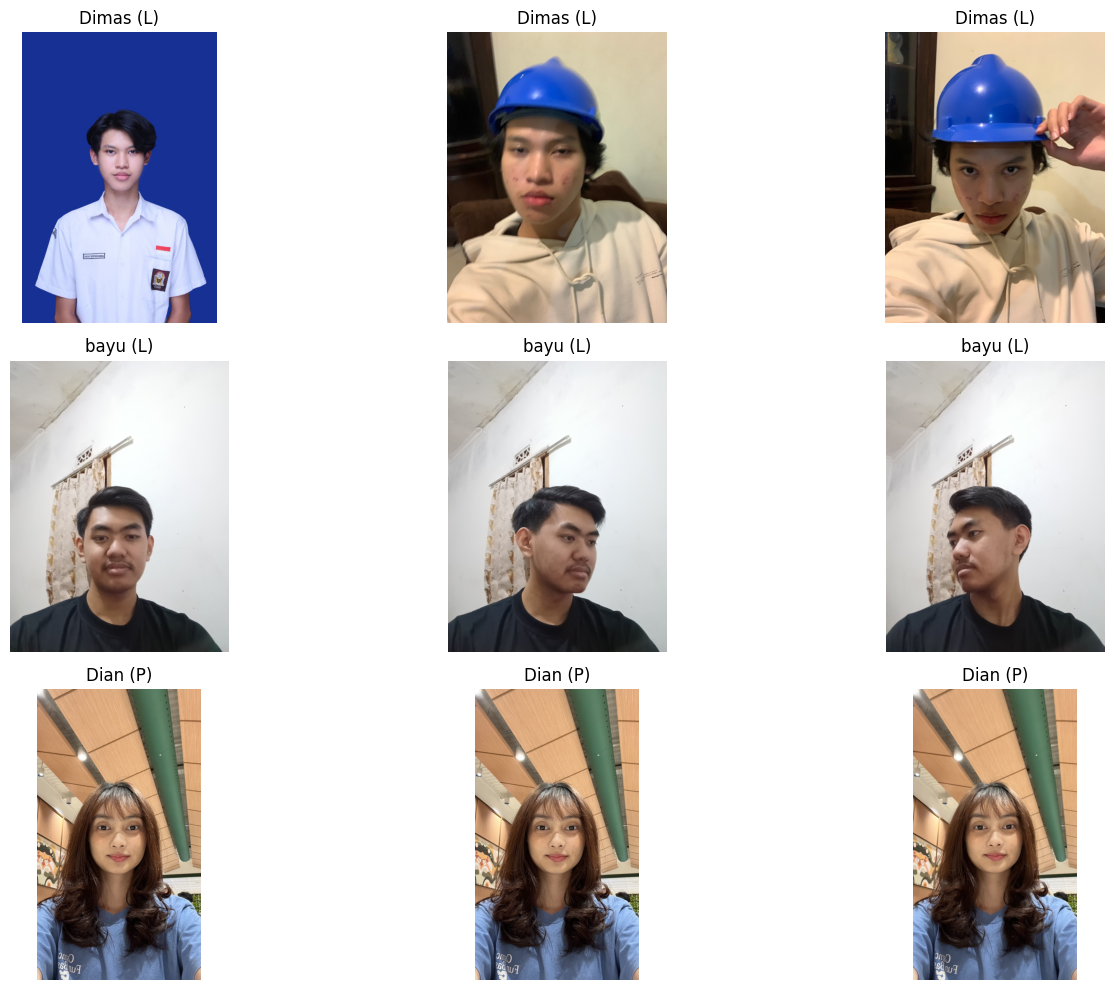

In [6]:
# Display sample images
plt.figure(figsize=(15, 10))
# Ambil label unik
unique_labels = list(set(labels))
# Fungsi untuk mengambil nama dan L/P dari nama file dan folder
def get_name_gender(idx, local_idx):
    name = labels[idx]
    # Cari folder yang sesuai dengan nama
    folder_candidates = [d for d in os.listdir(dataset_dir) if name in d]
    if folder_candidates:
        folder = folder_candidates[0]
        folder_path = os.path.join(dataset_dir, folder)
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg','.png'))]
        if local_idx < len(image_files):
            img_file = image_files[local_idx]
            parts = img_file.split('_')
            if len(parts) > 1:
                gender = parts[1]
            else:
                gender = "?"
        else:
            gender = "?"
    else:
        gender = "?"
    return f"{name} ({gender})"
# Ambil index gambar untuk masing-masing orang
indices_a = [i for i, l in enumerate(labels) if l == unique_labels[0]]
indices_b = [i for i, l in enumerate(labels) if len(unique_labels) > 1 and l == unique_labels[1]]
indices_c = [i for i, l in enumerate(labels) if len(unique_labels) > 2 and l == unique_labels[2]]
# Baris 1: orang pertama
for i in range(3):
    if i < len(indices_a):
        idx = indices_a[i]
        plt.subplot(3, 3, i+1)
        plt.imshow(images[idx])
        plt.title(get_name_gender(idx, i))
        plt.axis("off")
# Baris 2: orang kedua
for i in range(3):
    if len(unique_labels) > 1 and i < len(indices_b):
        idx = indices_b[i]
        plt.subplot(3, 3, 3+i+1)
        plt.imshow(images[idx])
        plt.title(get_name_gender(idx, i))
        plt.axis("off")
# Baris 3: orang ketiga jika ada, jika tidak gabungan a dan b
for i in range(3):
    plt.subplot(3, 3, 6+i+1)
    if len(unique_labels) > 2 and i < len(indices_c):
        idx = indices_c[i]
        plt.imshow(images[idx])
        plt.title(get_name_gender(idx, i))
        plt.axis("off")
plt.tight_layout()
plt.show()

In [7]:
# Check image dimensions
image_shapes = [img.shape for img in images]
unique_shapes = set([(h, w) for h, w, _ in image_shapes])
print(f"Unique image dimensions: {unique_shapes}")

Unique image dimensions: {(2170, 1628), (1280, 619), (2343, 1757), (1707, 1281), (2317, 1738), (2157, 1618), (2470, 1852), (2387, 1790), (2361, 1771), (2164, 1623), (2211, 1658), (2285, 1714), (3264, 1836), (2035, 1526), (2061, 1545), (2092, 1569), (2238, 1678), (2066, 1550), (2186, 1640), (2332, 1749), (2435, 1826), (2358, 1777), (2125, 1593), (1489, 1117), (1567, 1045), (2106, 1579), (2246, 1684), (2797, 2098), (2543, 1907), (1920, 1080), (3088, 2316), (2184, 1638), (2374, 1780), (2348, 1761), (2214, 1660), (1507, 1130), (1544, 1158), (2414, 1810), (2425, 1819), (2089, 1567), (2235, 1676), (2152, 1614), (1475, 1106), (2243, 1683), (2039, 1529), (3264, 1472), (2123, 1592), (2440, 1830), (2160, 1620), (2420, 1815), (3264, 2448), (2353, 1764), (2251, 1689), (2397, 1798), (2200, 1650), (2233, 1674), (2010, 1507), (2377, 1782), (2182, 1637), (1436, 1158), (2328, 1746), (1598, 1199), (2219, 1665), (2025, 1519), (2449, 1837), (2423, 1818), (2202, 1651), (2448, 2448), (2540, 1905), (2179, 16

In [8]:
# Standardize image size if needed
target_size = (128, 128)  # Choose an appropriate size

def resize_images(images, target_size):
    resized_images = []
    for img in tqdm(images):
        resized = cv2.resize(img, target_size)
        resized_images.append(resized)
    return resized_images

# Resize images if they have different dimensions
if len(unique_shapes) > 1:
    print(f"Resizing all images to {target_size}...")
    images = resize_images(images, target_size)
    print("Resizing complete.")

Resizing all images to (128, 128)...


100%|██████████| 450/450 [00:02<00:00, 154.84it/s]

Resizing complete.


## 3. Feature Extraction Methods

### 3.1 RGB Features

In [9]:
def extract_rgb_features(images):
    rgb_features = []
    
    for img in tqdm(images):
        # Calculate mean and standard deviation for each channel
        r_mean, g_mean, b_mean = np.mean(img[:,:,0]), np.mean(img[:,:,1]), np.mean(img[:,:,2])
        r_std, g_std, b_std = np.std(img[:,:,0]), np.std(img[:,:,1]), np.std(img[:,:,2])
        
        # Calculate histograms for each channel
        r_hist = np.histogram(img[:,:,0], bins=32, range=(0, 256))[0]
        g_hist = np.histogram(img[:,:,1], bins=32, range=(0, 256))[0]
        b_hist = np.histogram(img[:,:,2], bins=32, range=(0, 256))[0]
        
        # Combine features
        features = np.concatenate([
            [r_mean, g_mean, b_mean, r_std, g_std, b_std],
            r_hist, g_hist, b_hist
        ])
        
        rgb_features.append(features)
    
    return np.array(rgb_features)

# Extract RGB features
print("Extracting RGB features...")
rgb_features = extract_rgb_features(images)
print(f"RGB features shape: {rgb_features.shape}")

Extracting RGB features...


100%|██████████| 450/450 [00:00<00:00, 1085.89it/s]

RGB features shape: (450, 102)


### 3.2 HSV Features

In [10]:
def extract_hsv_features(images):
    hsv_features = []
    
    for img in tqdm(images):
        # Convert RGB to HSV
        hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        
        # Calculate mean and standard deviation for each channel
        h_mean, s_mean, v_mean = np.mean(hsv_img[:,:,0]), np.mean(hsv_img[:,:,1]), np.mean(hsv_img[:,:,2])
        h_std, s_std, v_std = np.std(hsv_img[:,:,0]), np.std(hsv_img[:,:,1]), np.std(hsv_img[:,:,2])
        
        # Calculate histograms for each channel
        h_hist = np.histogram(hsv_img[:,:,0], bins=32, range=(0, 180))[0]  # Hue range is 0-179 in OpenCV
        s_hist = np.histogram(hsv_img[:,:,1], bins=32, range=(0, 256))[0]
        v_hist = np.histogram(hsv_img[:,:,2], bins=32, range=(0, 256))[0]
        
        # Combine features
        features = np.concatenate([
            [h_mean, s_mean, v_mean, h_std, s_std, v_std],
            h_hist, s_hist, v_hist
        ])
        
        hsv_features.append(features)
    
    return np.array(hsv_features)

# Extract HSV features
print("Extracting HSV features...")
hsv_features = extract_hsv_features(images)
print(f"HSV features shape: {hsv_features.shape}")

Extracting HSV features...


100%|██████████| 450/450 [00:00<00:00, 1089.97it/s]

HSV features shape: (450, 102)


### 3.3 HoG (Histogram of Oriented Gradients) Features

In [11]:
def extract_hog_features(images):
    hog_features = []
    
    for img in tqdm(images):
        # Convert to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # Extract HOG features
        features, hog_image = hog(
            gray_img, 
            orientations=9, 
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2), 
            visualize=True, 
            block_norm="L2-Hys"
        )
        
        hog_features.append(features)
    
    return np.array(hog_features)

# Extract HOG features
print("Extracting HOG features...")
hog_features = extract_hog_features(images)
print(f"HOG features shape: {hog_features.shape}")

Extracting HOG features...


100%|██████████| 450/450 [00:11<00:00, 38.49it/s]

HOG features shape: (450, 8100)


### 3.4 GLCM (Gray Level Co-occurrence Matrix) Features

In [12]:
def extract_glcm_features(images):
    glcm_features = []
    
    # GLCM properties to calculate
    properties = ["contrast", "dissimilarity", "homogeneity", "energy", "correlation", "ASM"]
    
    for img in tqdm(images):
        # Convert to grayscale and scale to 0-255
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # Reduce gray levels to make computation more efficient
        gray_img = (gray_img / 16).astype(np.uint8)
        
        # Calculate GLCM for different angles
        distances = [1, 3, 5]  # Pixel distances
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # 0, 45, 90, 135 degrees
        
        features = []
        
        for distance in distances:
            glcm = graycomatrix(gray_img, [distance], angles, levels=16, symmetric=True, normed=True)
            
            for prop in properties:
                feature = graycoprops(glcm, prop).flatten()
                features.extend(feature)
        
        glcm_features.append(features)
    
    return np.array(glcm_features)

# Extract GLCM features
print("Extracting GLCM features...")
glcm_features = extract_glcm_features(images)
print(f"GLCM features shape: {glcm_features.shape}")

Extracting GLCM features...


100%|██████████| 450/450 [00:00<00:00, 695.28it/s]

GLCM features shape: (450, 72)


## 4. Save Extracted Features to CSV Files

In [13]:
# Create a directory for saving CSV files
csv_dir = "extracted_features"
os.makedirs(csv_dir, exist_ok=True)

In [14]:
# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Check the encoded labels
print(f"Original labels (first 5): {labels[:5]}")
print(f"Encoded labels (first 5): {encoded_labels[:5]}")
print(f"Number of unique classes: {len(np.unique(encoded_labels))}")
print(f"Unique encoded labels: {np.unique(encoded_labels)}")

Original labels (first 5): ['Dimas', 'Dimas', 'Dimas', 'Dimas', 'Dimas']
Encoded labels (first 5): [1 1 1 1 1]
Number of unique classes: 3
Unique encoded labels: [0 1 2]


In [15]:
# Function to save features to CSV
def save_features_to_csv(features, feature_name):
    # Create feature column names
    feature_cols = [f"{feature_name}_{i}" for i in range(features.shape[1])]
    
    # Create DataFrame
    df = pd.DataFrame(features, columns=feature_cols)
    df["label"] = labels
    df["encoded_label"] = encoded_labels
    
    # Save to CSV
    csv_path = os.path.join(csv_dir, f"{feature_name}_features.csv")
    df.to_csv(csv_path, index=False)
    print(f"Saved {feature_name} features to {csv_path}")
    
    return df

# Save all features to CSV
rgb_df = save_features_to_csv(rgb_features, "rgb")
hsv_df = save_features_to_csv(hsv_features, "hsv")
hog_df = save_features_to_csv(hog_features, "hog")
glcm_df = save_features_to_csv(glcm_features, "glcm")

Saved rgb features to extracted_features\rgb_features.csv
Saved hsv features to extracted_features\hsv_features.csv
Saved hog features to extracted_features\hog_features.csv
Saved glcm features to extracted_features\glcm_features.csv


## 5. Build MLP Models with Different Activation Functions

In [16]:
# Define activation functions to test
activation_functions = [
    "sigmoid",
    "relu",
    "tanh",
    "elu",
    "selu",
    "softplus",
    "softsign",
    "swish",
    "gelu",
    "leaky_relu"
]

In [17]:
# Custom activation functions that aren't directly available in Keras
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

def leaky_relu(x):
    return tf.nn.leaky_relu(x, alpha=0.01)

# Dictionary to map activation function names to their implementations
activation_map = {
    "sigmoid": "sigmoid",
    "relu": "relu",
    "tanh": "tanh",
    "elu": "elu",
    "selu": "selu",
    "softplus": "softplus",
    "softsign": "softsign",
    "swish": "swish",
    "gelu": gelu,
    "leaky_relu": leaky_relu
}

In [18]:
# Function to build MLP model with specified activation function
def build_mlp_model(input_shape, num_classes, activation, hidden_layers=[128, 64]):
    model = Sequential()
    
    # Input layer using Input layer to avoid warnings
    model.add(Input(shape=(input_shape,)))
    
    # First hidden layer
    model.add(Dense(hidden_layers[0], activation=activation_map[activation]))
    model.add(Dropout(0.3))
    
    # Additional hidden layers
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation=activation_map[activation]))
        model.add(Dropout(0.3))
    
    # Output layer (always uses softmax for multi-class classification)
    # Make sure num_classes is correct (should be > 1 for softmax)
    model.add(Dense(num_classes, activation="softmax"))
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    return model

## 6. Train and Evaluate Models with Different Feature Sets and Activation Functions

In [19]:
# Define feature sets to test
feature_sets = {
    "rgb": rgb_features,
    "hsv": hsv_features,
    "hog": hog_features,
    "glcm": glcm_features
}

In [20]:
# Function to train and evaluate model
def train_and_evaluate(X, y, activation, feature_name):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Get number of classes
    num_classes = len(np.unique(y))
    print(f"Number of classes: {num_classes}")
    
    # Build model
    model = build_mlp_model(X.shape[1], num_classes, activation)
    
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=50,  # Reduced from 100 to speed up training
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1  # Changed to 1 to show progress
    )
    
    # Evaluate model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    
    # Predictions
    y_pred = np.argmax(model.predict(X_test), axis=1)
    
    # Classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Return results
    return {
        "model": model,
        "history": history,
        "accuracy": accuracy,
        "loss": loss,
        "report": report,
        "confusion_matrix": cm,
        "y_test": y_test,
        "y_pred": y_pred
    }

In [21]:
# Store results
results = {}

# Train and evaluate models for each feature set and activation function
# For testing, let's just use one feature set and one activation function first
test_feature_name = "rgb"
test_activation = "relu"

print(f"\nTesting with {test_feature_name} features and {test_activation} activation...")
test_result = train_and_evaluate(feature_sets[test_feature_name], encoded_labels, test_activation, test_feature_name)
print(f"Test accuracy: {test_result['accuracy']:.4f}")


Testing with rgb features and relu activation...
Number of classes: 3
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5128 - loss: 1.0604 - val_accuracy: 0.8611 - val_loss: 0.5943
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7531 - loss: 0.6068 - val_accuracy: 0.8889 - val_loss: 0.4356
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8578 - loss: 0.4477 - val_accuracy: 0.9028 - val_loss: 0.3529
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8986 - loss: 0.3581 - val_accuracy: 0.9306 - val_loss: 0.2941
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8878 - loss: 0.3384 - val_accuracy: 0.9306 - val_loss: 0.2602
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9124 - loss: 0.2260 - val_accuracy: 0.9306 - val_loss: 0.2411
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9243 - loss: 0.2498 - val_accuracy: 0.9306 - val_loss: 0.2180
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 

In [22]:
# If the test was successful, run for all feature sets and activation functions
# Store results
results = {}

# Train and evaluate models for each feature set and activation function
for feature_name, features in feature_sets.items():
    results[feature_name] = {}
    
    print(f"\nTraining models with {feature_name} features...")
    
    for activation in activation_functions:
        print(f"  Training with {activation} activation...")
        results[feature_name][activation] = train_and_evaluate(features, encoded_labels, activation, feature_name)
        print(f"    Test accuracy: {results[feature_name][activation]['accuracy']:.4f}")


Training models with rgb features...
  Training with sigmoid activation...
Number of classes: 3
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3511 - loss: 1.1982 - val_accuracy: 0.7361 - val_loss: 0.9541
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4162 - loss: 1.0537 - val_accuracy: 0.6528 - val_loss: 0.8550
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5937 - loss: 0.8919 - val_accuracy: 0.7083 - val_loss: 0.7789
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6029 - loss: 0.8874 - val_accuracy: 0.7361 - val_loss: 0.7295
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6251 - loss: 0.7737 - val_accuracy: 0.7500 - val_loss: 0.6951
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6606 - loss: 0.7486 - val_accuracy: 0.7639 - val_loss: 0.6693
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6830 - loss: 0.7189 - val_accuracy: 0.7500 - val_loss: 0.6467
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━

## 7. Compare Performance Metrics Across Different Activation Functions

In [23]:
# Create a summary DataFrame of results
summary_data = []

for feature_name in feature_sets.keys():
    for activation in activation_functions:
        result = results[feature_name][activation]
        summary_data.append({
            "Feature": feature_name,
            "Activation": activation,
            "Accuracy": result["accuracy"],
            "Loss": result["loss"],
            "F1-Score (Weighted)": result["report"]["weighted avg"]["f1-score"],
            "Precision (Weighted)": result["report"]["weighted avg"]["precision"],
            "Recall (Weighted)": result["report"]["weighted avg"]["recall"]
        })

summary_df = pd.DataFrame(summary_data)
summary_df

,Feature,Activation,Accuracy,Loss,F1-Score (Weighted),Precision (Weighted),Recall (Weighted)
0,rgb,sigmoid,0.911111,0.200723,0.909420,0.915193,0.911111
1,rgb,relu,0.966667,0.120280,0.966475,0.966642,0.966667
2,rgb,tanh,0.922222,0.229028,0.921090,0.924618,0.922222
3,rgb,elu,0.944444,0.185030,0.943924,0.948192,0.944444
4,rgb,selu,0.933333,0.242687,0.932319,0.938447,0.933333
5,rgb,softplus,0.944444,0.168745,0.943924,0.948192,0.944444
6,rgb,softsign,0.933333,0.234603,0.931217,0.939394,0.933333
7,rgb,swish,0.933333,0.169849,0.932750,0.933190,0.933333
8,rgb,gelu,0.944444,0.179603,0.944037,0.945040,0.944444
9,rgb,leaky_relu,0.933333,0.120688,0.932028,0.935096,0.933333


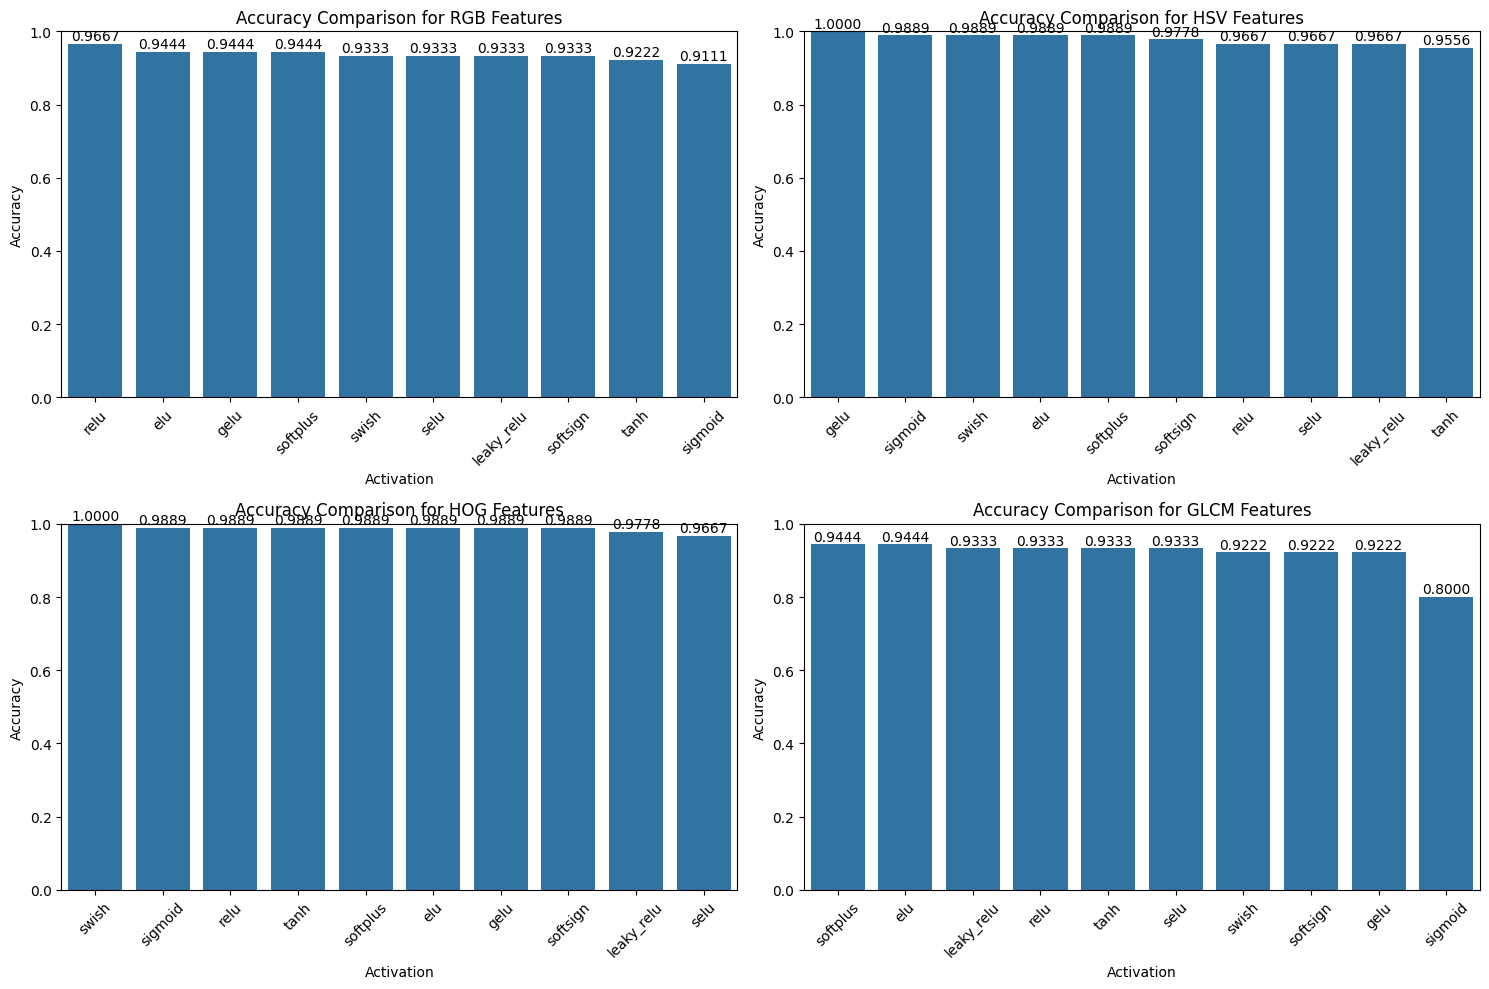

In [24]:
# Plot accuracy comparison for each feature set
plt.figure(figsize=(15, 10))

for i, feature_name in enumerate(feature_sets.keys()):
    plt.subplot(2, 2, i+1)
    
    feature_results = summary_df[summary_df["Feature"] == feature_name]
    feature_results = feature_results.sort_values("Accuracy", ascending=False)
    
    sns.barplot(x="Activation", y="Accuracy", data=feature_results)
    plt.title(f"Accuracy Comparison for {feature_name.upper()} Features")
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    
    # Add accuracy values on top of bars
    for j, v in enumerate(feature_results["Accuracy"]):
        plt.text(j, v + 0.01, f"{v:.4f}", ha="center")

plt.tight_layout()
plt.show()

## 8. Determine the Best Activation Function

In [25]:
# Find the best activation function for each feature set
best_activations = {}

for feature_name in feature_sets.keys():
    feature_results = summary_df[summary_df["Feature"] == feature_name]
    best_row = feature_results.loc[feature_results["Accuracy"].idxmax()]
    
    best_activations[feature_name] = {
        "activation": best_row["Activation"],
        "accuracy": best_row["Accuracy"],
        "f1_score": best_row["F1-Score (Weighted)"],
        "precision": best_row["Precision (Weighted)"],
        "recall": best_row["Recall (Weighted)"]
    }

# Display best activation functions
print("Best Activation Functions for Each Feature Set:")
for feature_name, best in best_activations.items():
    print(f"\n{feature_name.upper()} Features:")
    print(f"  Best Activation: {best['activation']}")
    print(f"  Accuracy: {best['accuracy']:.4f}")
    print(f"  F1-Score: {best['f1_score']:.4f}")
    print(f"  Precision: {best['precision']:.4f}")
    print(f"  Recall: {best['recall']:.4f}")

# Find overall best feature set and activation function
best_feature = max(best_activations.items(), key=lambda x: x[1]["accuracy"])[0]
best_activation = best_activations[best_feature]["activation"]
best_accuracy = best_activations[best_feature]["accuracy"]

print(f"\nOverall Best Combination:")
print(f"  Feature Set: {best_feature.upper()}")
print(f"  Activation Function: {best_activation}")
print(f"  Accuracy: {best_accuracy:.4f}")

Best Activation Functions for Each Feature Set:

RGB Features:
  Best Activation: relu
  Accuracy: 0.9667
  F1-Score: 0.9665
  Precision: 0.9666
  Recall: 0.9667

HSV Features:
  Best Activation: gelu
  Accuracy: 1.0000
  F1-Score: 1.0000
  Precision: 1.0000
  Recall: 1.0000

HOG Features:
  Best Activation: swish
  Accuracy: 1.0000
  F1-Score: 1.0000
  Precision: 1.0000
  Recall: 1.0000

GLCM Features:
  Best Activation: elu
  Accuracy: 0.9444
  F1-Score: 0.9442
  Precision: 0.9451
  Recall: 0.9444

Overall Best Combination:
  Feature Set: HSV
  Activation Function: gelu
  Accuracy: 1.0000


Number of classes: 3
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3120 - loss: 1.3536 - val_accuracy: 0.7639 - val_loss: 0.8134
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6869 - loss: 0.7383 - val_accuracy: 0.8472 - val_loss: 0.5562
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8092 - loss: 0.5323 - val_accuracy: 0.9167 - val_loss: 0.4269
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8973 - loss: 0.3802 - val_accuracy: 0.9444 - val_loss: 0.3410
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9405 - loss: 0.2855 - val_accuracy: 0.9444 - val_loss: 0.2818
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9328 - loss: 0.2311 - val_accuracy: 0.9444 - val_loss: 0.2399
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9684 - loss: 0.1599 - val_accuracy: 0.9444 - val_loss: 0.2140
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9724 - loss: 0.1216 - val_accuracy: 0.9306 - val

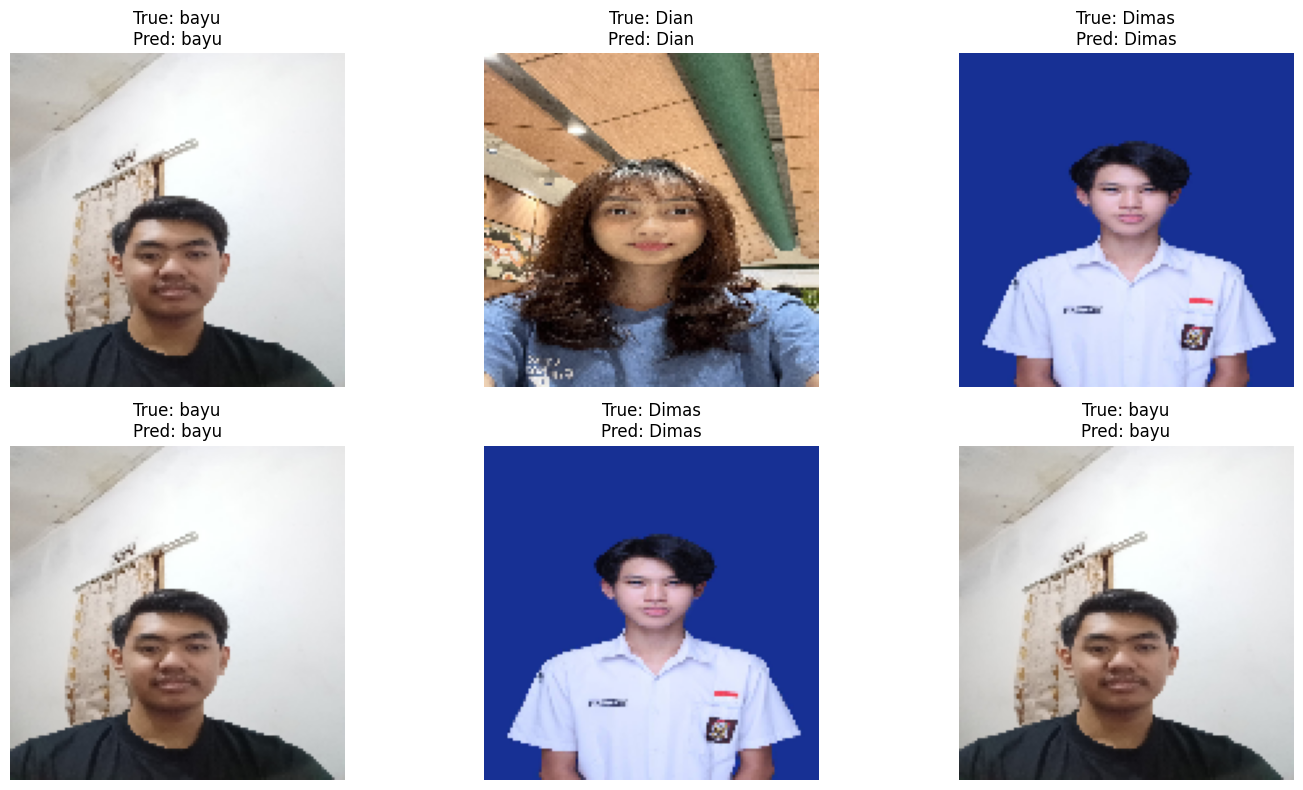

In [28]:
# Visualisasi hasil prediksi pada gambar test set
num_samples = 6
test_feature_name = "hsv"  # Ganti sesuai fitur yang ingin diuji
test_activation = "gelu"  # Ganti sesuai aktivasi yang ingin diuji
X = feature_sets[test_feature_name]
y = encoded_labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
model_result = train_and_evaluate(X, y, test_activation, test_feature_name)
plt.figure(figsize=(15, 8))
for i in range(num_samples):
    # Ambil index asli dari test set
    idx = np.where((encoded_labels == y_test[i]))[0][0]
    plt.subplot(2, 3, i+1)
    plt.imshow(images[idx])
    true_label = label_encoder.inverse_transform([y_test[i]])[0]
    pred_label = label_encoder.inverse_transform([model_result['y_pred'][i]])[0]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()

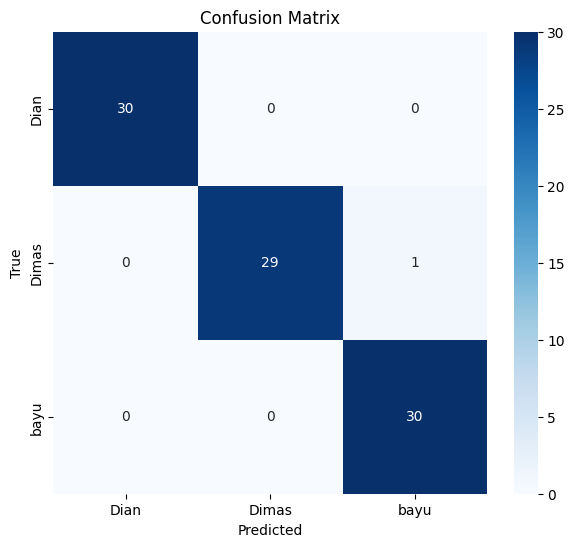

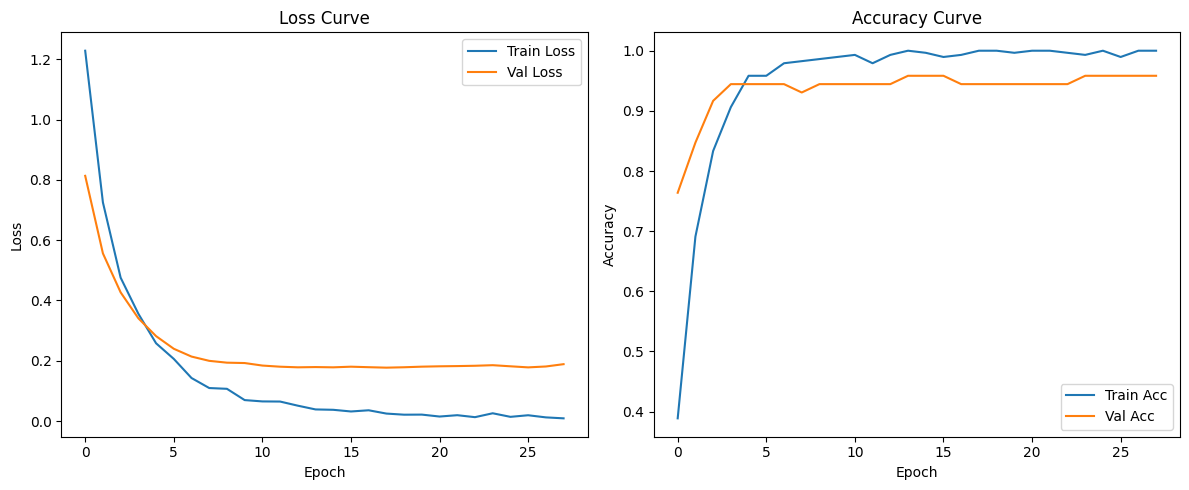

In [29]:
# Visualisasi Confusion Matrix dan Loss Curve untuk model yang diuji
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Gunakan hasil dari model_result pada cell sebelumnya
cm = model_result['confusion_matrix']
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Visualisasi Loss dan Akurasi selama training
history = model_result['history']
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.tight_layout()
plt.show()